In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sms-spam-collection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F483%2F982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240917%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240917T103336Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D92be387813011b325bbb8f492ba9c34c4c56e5174c3ece9f96a76d6897338976b4aa00d3a392ad4cc86ba95e5b919ba795a3bab1c23cc60db41e4ed68e97c4c99ea0bdf0e4732ce7d73acb7c456fa0351416da2e51a71768b4fe636b684fa61545a4b1227f75db403f23e433ae7b14b887b5439bb0313ccb53753eced21df5440de0d62cae6249aadc088697639b3ce2064d014645aefba994fb353a1151495deabffa6cb4d5f031805a41c9ba062a6157d5cfb74dc7e344dafad9e3d8030836ed4abcf8b3b50644ed9e57526a7859fc6462edffc84b6fee403550f7c82cb426ce6e223dcba1edf9944dda2d24776236f4dabdac9d00255c6b00e7eae00bd4b1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 215934 bytes downloaded
Downloaded and uncompressed: sms-spam-collection-dataset
Data source import complete.


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
# Load the dataset
file_path = '/kaggle/input/sms-spam-collection-dataset/spam.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

In [5]:
# Display the first few rows of the dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# Retain only the necessary columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

In [7]:
# Check for missing values
df.isnull().sum()

,0
label,0
message,0


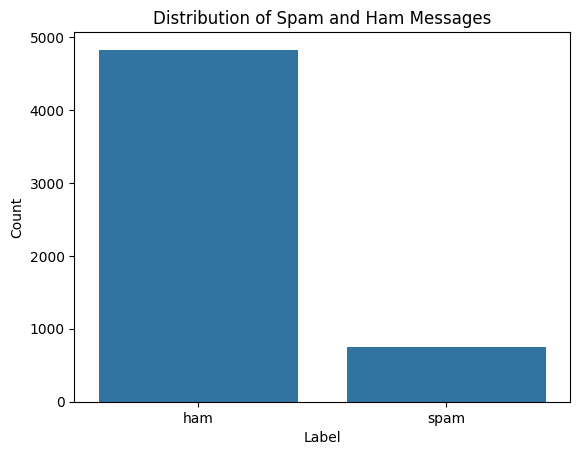

In [8]:
# Plot the distribution of spam and ham messages
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
# Convert text data to numerical data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['message'])
y = df['label'].map({'ham': 0, 'spam': 1})

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [13]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy, conf_matrix, class_report

(0.97847533632287,
 array([[952,  13],
        [ 11, 139]]),
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99       965\n           1       0.91      0.93      0.92       150\n\n    accuracy                           0.98      1115\n   macro avg       0.95      0.96      0.95      1115\nweighted avg       0.98      0.98      0.98      1115\n')